In [10]:
import os
import glob
import shutil
import pathlib

import logging
import numpy as np
import matplotlib.pyplot as plt
from openquake.hazardlib.tom import PoissonTOM
from openquake.wkf.utils import _get_src_id, create_folder, get_list
from openquake.hazardlib.nrml import to_python
from openquake.hazardlib.geo.mesh import Mesh
from openquake.hazardlib.sourceconverter import SourceConverter
from openquake.mbt.tools.mfd import EEvenlyDiscretizedMFD
from openquake.hazardlib.sourcewriter import write_source_model
from openquake.hazardlib.source import SimpleFaultSource, MultiPointSource
from openquake.hazardlib.geo.surface import SimpleFaultSurface
from openquake.hazardlib.mfd.multi_mfd import MultiMFD

In [11]:
ffname = '../faults/faults.xml'
folder_oq_in = "../srcs/source*xml"
folder_oq_out = "oq"
distance = 10
magt = 6.5

In [12]:
from openquake.wkf.distributed_seismicity import get_data

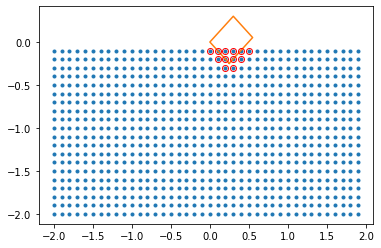

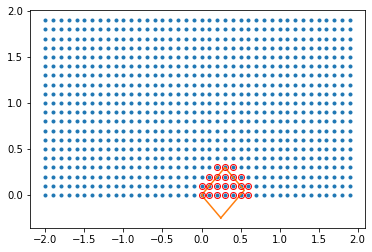

In [13]:
#if len(use) > 0:
#        use = get_list(use)
use = ''
# Load fault sources
binw = 0.1
sourceconv = SourceConverter(investigation_time=1.0,
                             rupture_mesh_spacing=5.0,
                             complex_fault_mesh_spacing=5.0,
                             width_of_mfd_bin=binw)
ssm_faults = to_python(ffname, sourceconv)

# Loading all the point sources in the distributed seismicity model
#    coo_pnt_src = []
#    pnt_srcs = []
ii = 0
dst = 10
for fname in glob.glob(folder_oq_in):
    coo_pnt_src = []
    pnt_srcs = []

    # Info
    logging.info(f'Processing: {fname}')

    # Check if the source must be processed
    src_id = _get_src_id(fname)
    if len(use) > 0 and src_id not in use:
        logging.info(f'Skipping {fname}')
        continue
        
    tssm = to_python(fname, sourceconv)
    
    tcoo = np.array([(p.location.longitude, p.location.latitude) for p in
                         tssm[0]])
    pnt_srcs.extend(tssm[0])
    coo_pnt_src.extend(tcoo)

    coo_pnt_src = np.array(coo_pnt_src)

    # Getting the list of faults
    faults = []
    for grp in ssm_faults:
        for s in grp:
            faults.append(s)

    fig, axs = plt.subplots(1, 1)
    plt.plot(coo_pnt_src[:, 0], coo_pnt_src[:, 1], '.') 
    buffer_pts = []
    bco = []
    src = faults[0]

    # Getting the subset of point sources in the surrounding of the fault
    # `src`. `coo_pnt_src` is a numpy.array with two columns (i.e. lon and 
    # lat). `pnt_srcs` is a list containing the point sources that 
    # collectively describe the distributed seismicity souces provided as
    # input
    coo = np.array(src.polygon.coords)
    plt.plot(coo[:,0],coo[:,1])
    #bbox = get_bounding_box(src)
    pnt_ii, sel_pnt_srcs, sel_pnt_coo, rrup = get_data(src, coo_pnt_src,
                                                       pnt_srcs)
    if pnt_ii is not None:
    
        # Find the index of points within the buffer zone
        within_idx = np.nonzero(rrup < dst)[0]
        idxs = sorted([pnt_ii[i] for i in within_idx], reverse=True)

        plt.plot(coo_pnt_src[idxs, 0], coo_pnt_src[idxs, 1], 'or', mfc='none')

In [14]:
len(idxs)

22

In [15]:
np.array(src.polygon.coords)

array([[ 0.24783, -0.24782],
       [ 0.     ,  0.     ],
       [ 0.3    ,  0.3    ],
       [ 0.54782,  0.05218],
       [ 0.24783, -0.24782]])

In [16]:
buffer = 1
idxs = np.nonzero((coo_pnt_src[:, 0] > bbox[0]-buffer) &
                  (coo_pnt_src[:, 1] > bbox[1]-buffer) &
                  (coo_pnt_src[:, 0] < bbox[2]+buffer) &
                  (coo_pnt_src[:, 1] < bbox[3]+buffer))[0]
sel_pnt_srcs = [pnt_srcs[i] for i in idxs]

# No points selected
#if len(sel_pnt_srcs) < 1:
#    return None, None, None, None

# Coordinates of the selected points i.e. points within the bounding box
# plus of the fault plus a buffers
sel_pnt_coo = np.array([(p.location.longitude, p.location.latitude) for p
                        in sel_pnt_srcs])

# Create the mesh
mesh = Mesh(sel_pnt_coo[:, 0], sel_pnt_coo[:, 1])

if isinstance(src, SimpleFaultSource):
    sfc = SimpleFaultSurface.from_fault_data(src.fault_trace,
                                             src.upper_seismogenic_depth, 
                                             src.lower_seismogenic_depth,
                                             src.dip, 1.0)
else:
    raise ValueError('Not supported fault type')
fault_perim = np.array(src.polygon.coords)

#rrup = sfc.get_min_distance(mesh)
rrup = sfc.get_joyner_boore_distance(mesh)



NameError: name 'bbox' is not defined

In [ ]:
fp = fault_perim[:-1]

In [ ]:
fmesh = Mesh(fp[:, 0], fp[:, 1]) 


In [ ]:
plt.scatter(mesh.array[0],mesh.array[1],c=rrup)
